# **Lane Line Detection for Autonomous Cars** 
***

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Test Images

Built my pipeline to work on the images in the directory "test_images"

In [2]:
import os

# print test images file name
os.listdir("test_images/")

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

#### Read in a Test Image

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


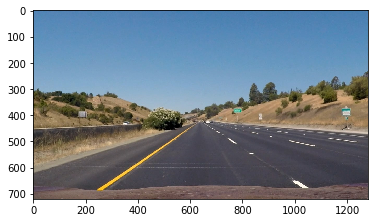

In [3]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

# printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image) 

# Camera Calibration

Calculate the correct camera matrix and distortion coefficients using the calibration chessboard images in the directory "camera_cal"

In [4]:
# list of calibration images file names
os.listdir("camera_cal/") 

['calibration1.jpg',
 'calibration10.jpg',
 'calibration11.jpg',
 'calibration12.jpg',
 'calibration13.jpg',
 'calibration14.jpg',
 'calibration15.jpg',
 'calibration16.jpg',
 'calibration17.jpg',
 'calibration18.jpg',
 'calibration19.jpg',
 'calibration2.jpg',
 'calibration20.jpg',
 'calibration3.jpg',
 'calibration4.jpg',
 'calibration5.jpg',
 'calibration6.jpg',
 'calibration7.jpg',
 'calibration8.jpg',
 'calibration9.jpg']

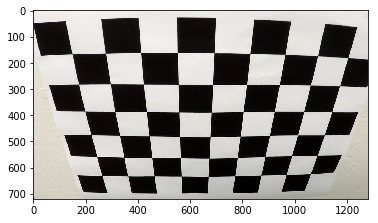

In [5]:
# show one of the calibration images
img = mpimg.imread('camera_cal/calibration9.jpg')
plt.imshow(img)

## Finding Corners in Calibration Images

In [6]:
print('Finding corners in all calibration images...')

# Arrays to store object points and image points from all the calibration images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (9,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coordinates

nx = 9 # number of chessboard inside corners in x
ny = 6 # number of chessboard inside corners in y
    
# Make a list of calibration images file names
calibration_images_names = os.listdir("camera_cal/")

for calibration_image_name in calibration_images_names:
    # Read each image
    img = cv2.imread('camera_cal/' + calibration_image_name)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If corners are found
    if ret == True:
        # add object points, image points
        imgpoints.append(corners)
        objpoints.append(objp)

print('Successfully found corners in all calibration images')

Finding corners in all calibration images...
Successfully found corners in all calibration images


Draw and display the corners in the last calibration image as an example

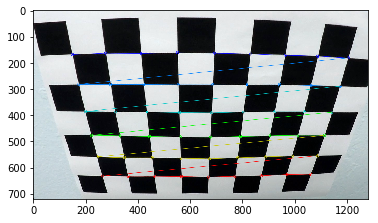

In [7]:
img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
plt.imshow(img)

## Correcting for Distortion

This function takes an image, object points, and image points, performs the camera calibration and image distortion correction and returns the undistorted image

In [8]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

Test distortion correction on a checkboard image

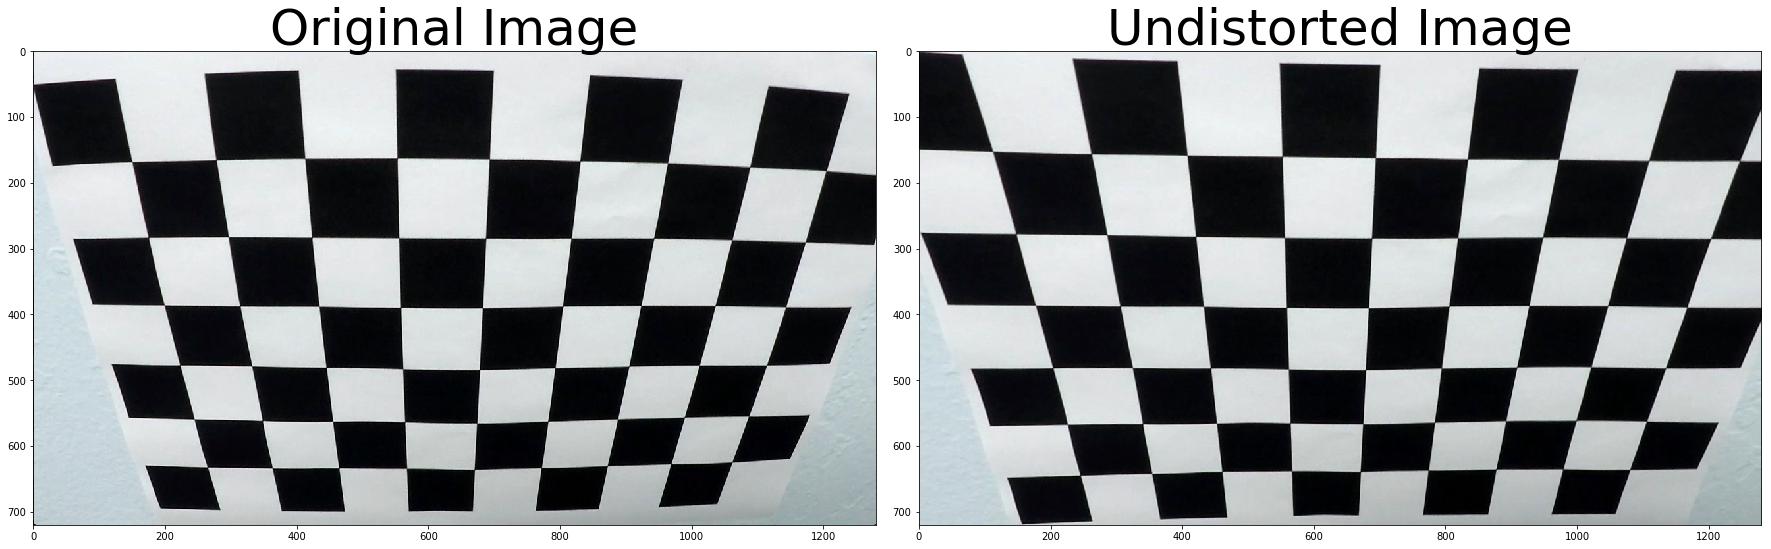

In [9]:
# Read image
img = cv2.imread('camera_cal/calibration9.jpg')

# Return undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

# plot original and unsdistorted images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Test distortion correction on a test image

Undistorted image saved in output_images directory.


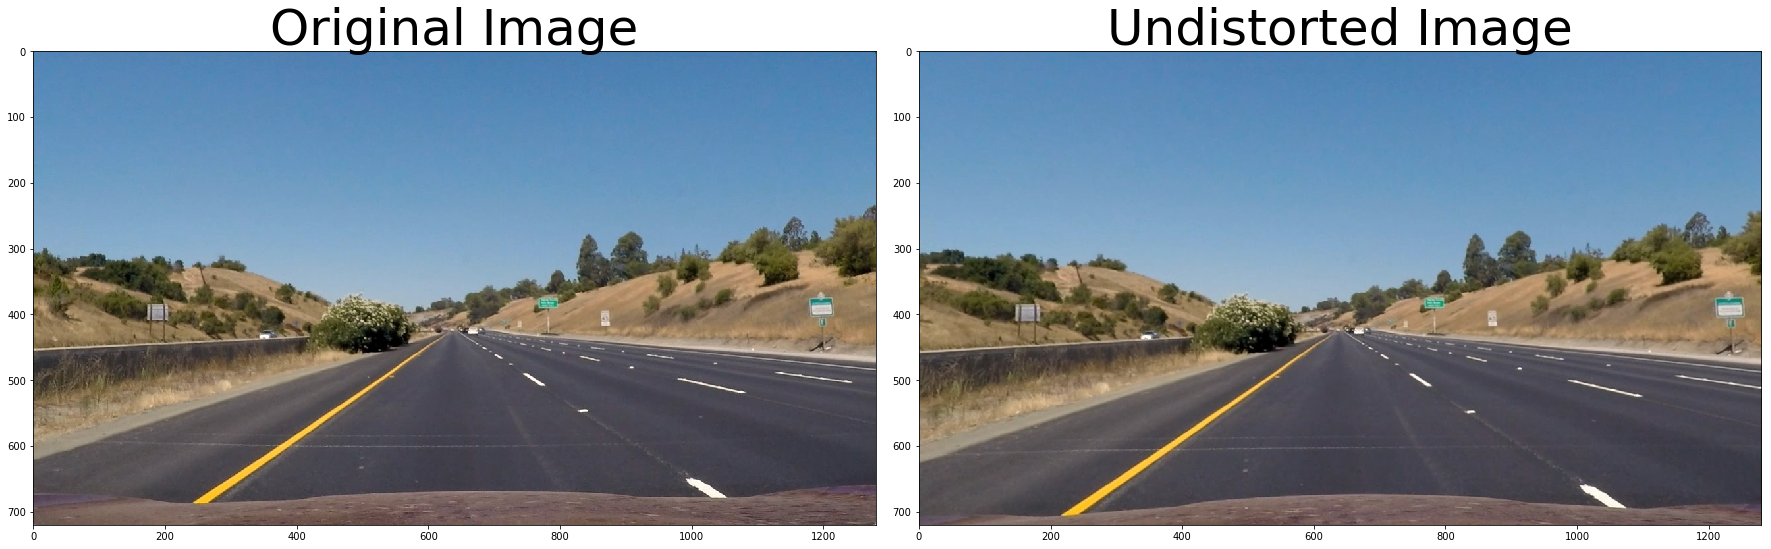

In [10]:
# Read image
img = mpimg.imread('test_images/straight_lines1.jpg')

# Return undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

# save undistorted image in 'output_images' folder
image_to_write = cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/straight_lines1-undistorted.jpg', image_to_write)
print('Undistorted image saved in output_images directory.')

# plot original and undistorted images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Finding Lane Lines

## Gradient Thresholding

This function takes an undistorted image, applies Sobel x and y,  then computes the magnitude of the gradient, applies a threshold and returns the gradient threshold binary output

In [11]:
def magnitude_threshold(undistorted, sobel_kernel=3, mag_thresh=(0, 255)):

    # Convert to grayscale
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_output

This function takes an undistorted image, applies Sobel x and y,  then computes the direction of the gradient, applies a threshold and returns the gradient threshold binary output

In [12]:
def direction_threshold(undistorted, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the absolute value of the gradient direction
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Create a mask of 1's where the absolute value of the gradient direction 
            # is > thresh_min and < thresh_max
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    return binary_output

Test Gradient Magnitude and Gradient  Direction Thresholdings on an undistorted test image

Combined Gradient Thresholdings binary image saved in output_images directory.


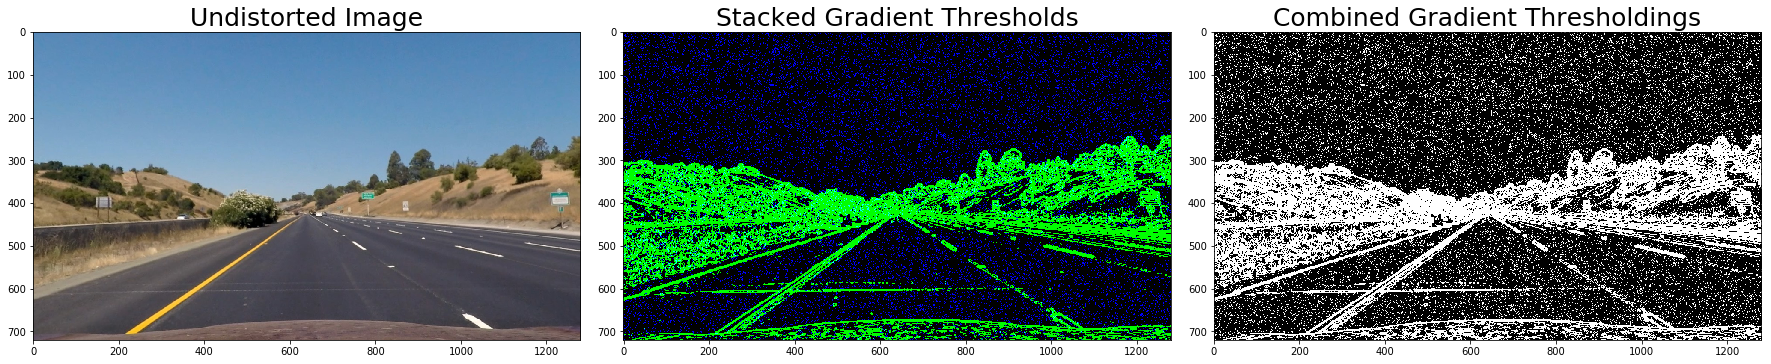

In [13]:
# Read test image
img = mpimg.imread('test_images/straight_lines1.jpg')

# Return undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

# Perform gradient magnitude thresholding
mag_binary = magnitude_threshold(undistorted, sobel_kernel=5, mag_thresh=(10,255))

# Perform gradient direction thresholding for vertical lines
dir_vertical_binary = direction_threshold(undistorted, sobel_kernel=5, dir_thresh=(0.6, 0.8))

# Stack each gradient thresholding to view their individual contributions 
  # in green (magnitude threshold) and blue (direction threshold)
gradient_contribution_binary = np.dstack(( np.zeros_like(mag_binary), mag_binary, dir_vertical_binary))

# Combine gradient magnitude and gradient direction thresholdings
gradient_binary = np.zeros_like(mag_binary)
gradient_binary[(mag_binary == 1) | (dir_vertical_binary == 1)] = 1

# Save Combined Gradient Thresholdings binary image in 'output_images' folder
image_to_write = np.dstack((gradient_binary, gradient_binary, gradient_binary))*255
cv2.imwrite('output_images/straight_lines1-gradientThresh.jpg', image_to_write)
print('Combined Gradient Thresholdings binary image saved in output_images directory.')

# plot undistorted and combined gradient thresholdings binary images side by side
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(gradient_contribution_binary, cmap='gray')
ax2.set_title('Stacked Gradient Thresholds', fontsize=25)
ax3.imshow(gradient_binary, cmap='gray')
ax3.set_title('Combined Gradient Thresholdings', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color Thresholding
Use S-channel thresholding for yellow lines and R-channel thresholding for white lines

This function takes an undistorted image, converts it from RGB to HLS color space, filters on the saturation channel, applies a threshold and returns the saturation threshold binary output

In [14]:
def saturation_threshold(undistorted, sat_thresh=(0, 255)):
    
    # Convert to HLS color space
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    
    # Filter on the S-channel from the HLS color space
    S = hls[:,:,2]
    
    # Apply a threshold to the S channel
    binary_output = np.zeros_like(S) 
    binary_output[(S > sat_thresh[0]) & (S <= sat_thresh[1])] = 1
    
    return binary_output

This function takes an undistorted image, filters on the red channel, applies a threshold and returns the red threshold binary output

In [15]:
def red_threshold(undistorted, red_thresh=(0, 255)):
    
    # Filter on the red channel from the RGB color space
    R = undistorted[:,:,0]
    
    # Apply a threshold to the red channel
    binary_output = np.zeros_like(R) 
    binary_output[(R > red_thresh[0]) & (R <= red_thresh[1])] = 1
    
    return binary_output

Test Saturation and Red Thresholdings on a undistorted test image

Combined Color Thresholdings binary image saved in output_images directory.


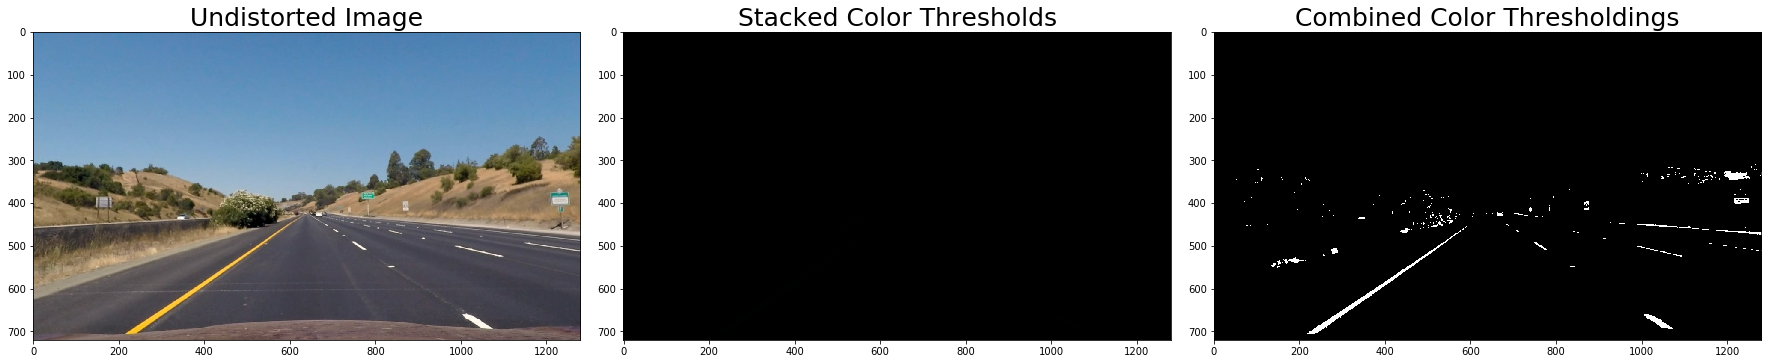

In [16]:
# Read original image
img = mpimg.imread('test_images/straight_lines1.jpg')

# Return undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

# Perform saturation-channel thresholding for yellow lines
s_binary = saturation_threshold(undistorted, sat_thresh=(200, 255))

# Perform red-channel thresholding for white lines
r_binary = red_threshold(undistorted, red_thresh=(200, 255))

# Stack each color thresholding to view their individual contributions
    # in green (saturation-channel) and blue (red-channel) 
color_contribution_binary = np.dstack(( np.zeros_like(s_binary), s_binary, r_binary))

# Combine saturation-channel and red-channel thresholdings
color_binary = np.zeros_like(s_binary)
color_binary[(s_binary == 1) | (r_binary == 1)] = 1

# Save Combined Color Thresholdings binary image in 'output_images' folder
image_to_write = np.dstack((color_binary, color_binary, color_binary))*255
cv2.imwrite('output_images/straight_lines1-colorThresh.jpg', image_to_write)
print('Combined Color Thresholdings binary image saved in output_images directory.')

# plot undistorted and combined color thresholdings binary images side by side
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(color_contribution_binary, cmap='gray')
ax2.set_title('Stacked Color Thresholds', fontsize=25)
ax3.imshow(color_binary, cmap='gray')
ax3.set_title('Combined Color Thresholdings', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combining Gradient and Color Thresholdings

This function takes an undistorted image, applies gradient magnitude & direction thresholdings and saturation-channel & red-channel thresholdings, and returns the combined gradient & color thresholds binary output

In [17]:
def combined_thresholds(undistorted, 
        sobel_kernel=3, mag_thresh=(0, 255), dir_thresh=(0, np.pi/2), 
        sat_thresh=(0, 255), red_thresh=(0, 255)):
    
    # Perform gradient magnitude thresholding
    mag_binary = magnitude_threshold(undistorted, sobel_kernel, mag_thresh)

    # Perform gradient direction thresholding for vertical lines
    dir_vertical_binary = direction_threshold(undistorted, sobel_kernel, dir_thresh)
    
    # Perform saturation-channel thresholding for yellow lines
    s_binary = saturation_threshold(undistorted, sat_thresh)

    # Perform red-channel thresholding for white lines
    r_binary = red_threshold(undistorted, red_thresh)
    
    # Combine gradient and color thresholdings
    combined_binary = np.zeros_like(mag_binary)
    combined_binary[((mag_binary == 1) | (dir_vertical_binary == 1)) & ((s_binary == 1) | (r_binary == 1))] = 1
    
    return combined_binary

Test Combined Gradient and Color Thresholdings on a undistorted test image

Combined Gradient and Color Thresholdings binary image saved in output_images directory.


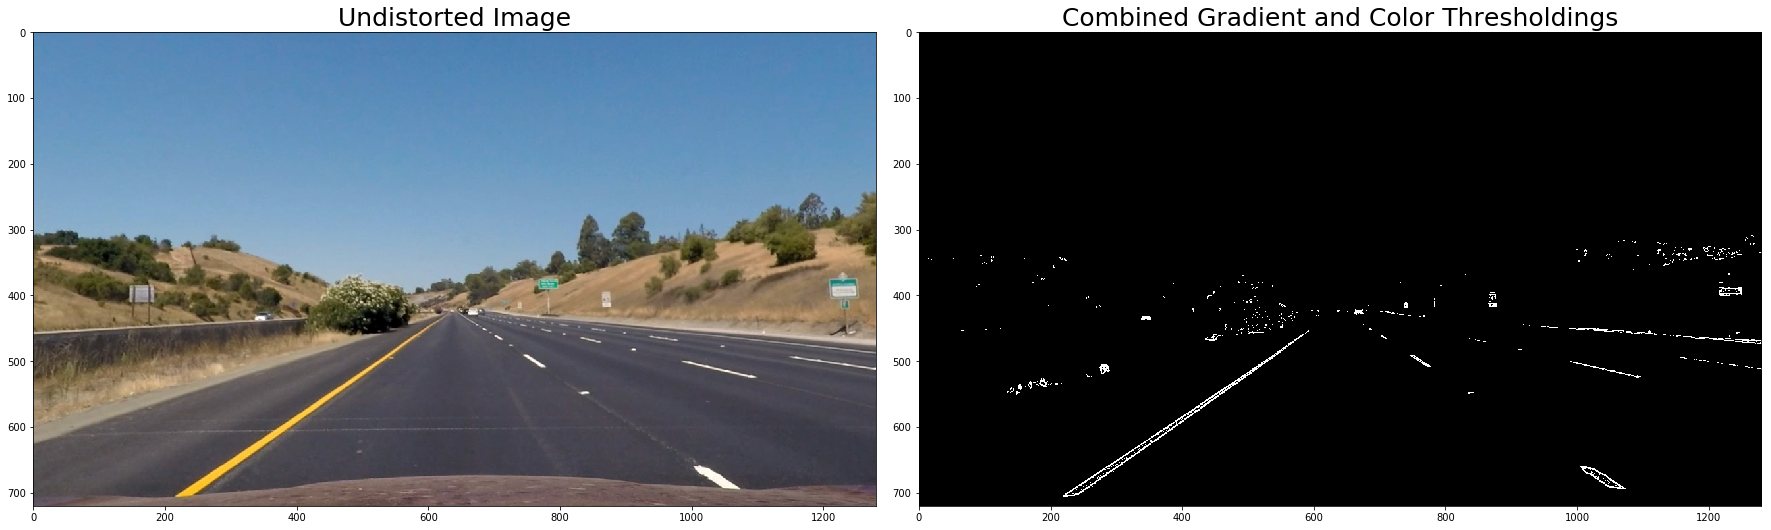

In [18]:
# Read original image
img = mpimg.imread('test_images/straight_lines1.jpg')

# Return undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

# Perform Combined Gradient and Color Thresholdings
combined_binary = combined_thresholds(undistorted, 
        sobel_kernel=5, mag_thresh=(10, 255), dir_thresh=(0.6, 0.8), 
        sat_thresh=(200, 255), red_thresh=(200, 255))

# Save Combined Gradient and Color Thresholdings binary image in 'output_images' folder
image_to_write = np.dstack((combined_binary, combined_binary, combined_binary))*255
cv2.imwrite('output_images/straight_lines1-combinedThresh.jpg', image_to_write)
print('Combined Gradient and Color Thresholdings binary image saved in output_images directory.')

# plot undistorted and combined Gradient and Color thresholdings binary images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined Gradient and Color Thresholdings', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective Transform
See the detected lane lines from a bird's eye view

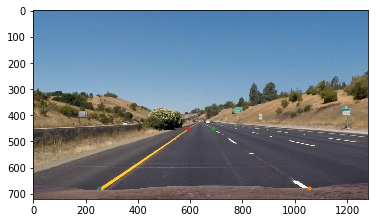

In [19]:
# Read undistorted test image
img = mpimg.imread('test_images/straight_lines1.jpg')

# Return undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

# set the source coordinates of the lane line
plt.imshow(img)
plt.plot(253,678,'.') # bottom left
plt.plot(1054,678,'.') # bottom right
plt.plot(688,450,'.') # top right
plt.plot(593,450,'.') # top left

This function takes an undistorted and thresholded image and returns the warped image

In [20]:
def warp(undist_thresh):
    
    # Grab the image shape
    img_size = (undist_thresh.shape[1], undist_thresh.shape[0])
    
    # Define calibration box in source (original) and destination (warped) coordinates
    src = np.float32(
        [[253,678], # bottom left
         [1054,678],  # bottom right
         [688,450], # top right
         [593,450]]) # top left
    dst = np.float32(
        [[253,720], # bottom left
         [1054,720],  # bottom right
         [1054,0], # top right
         [253,0]]) # top left
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist_thresh, M, img_size)

    return warped

Test perspective transform on an undistorted and thresholded test image

Warped binary image saved in output_images directory.


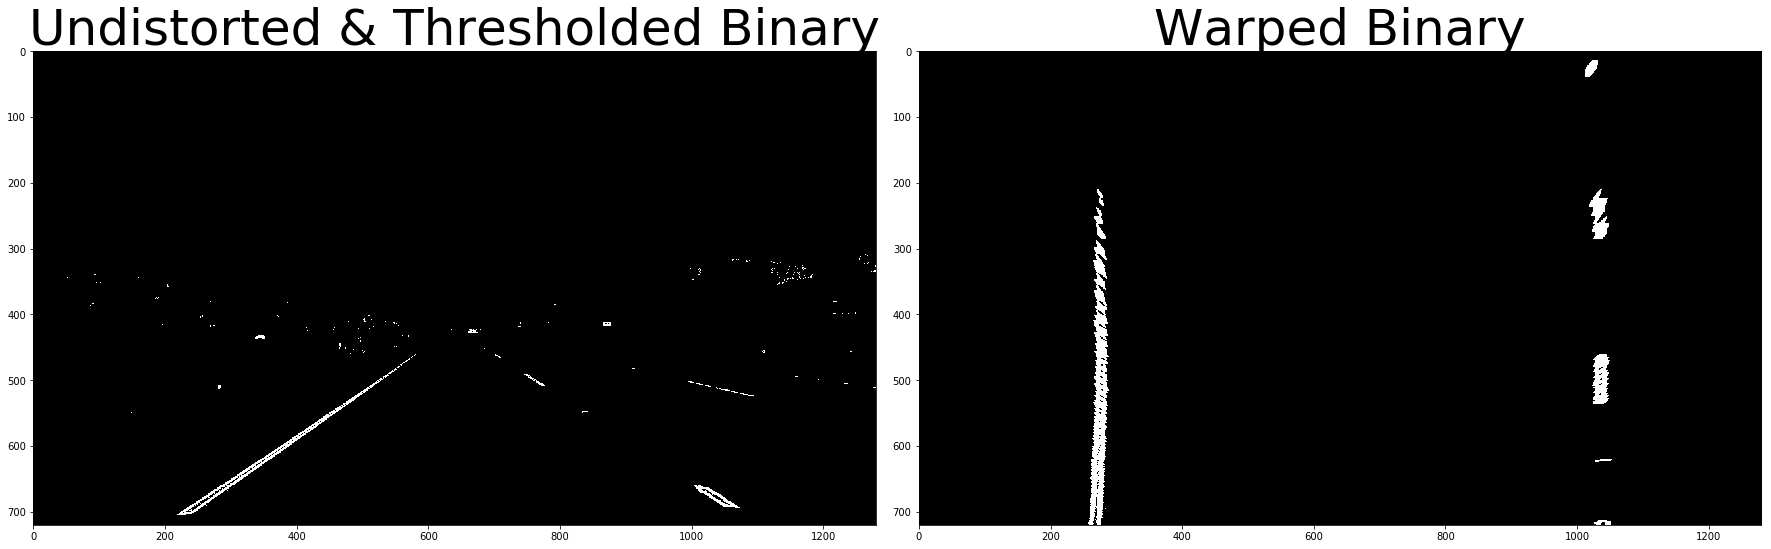

In [21]:
# Read original image
img = mpimg.imread('test_images/straight_lines1.jpg')

# Return undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

# Apply Combined Gradient & Color Thresholdings
undist_thresh = combined_thresholds(undistorted, 
    sobel_kernel=15, mag_thresh=(10, 255), dir_thresh=(0.6, 0.8), 
    sat_thresh=(200, 235), red_thresh=(220, 255))

# Return warped image
binary_warped = warp(undist_thresh)

# Save Warped Binary image in 'output_images' folder
image_to_write = np.dstack((binary_warped, binary_warped, binary_warped))*255
cv2.imwrite('output_images/straight_lines1-warped.jpg', image_to_write)
print('Warped binary image saved in output_images directory.')

# Plot original and undistorted & warped images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_thresh, cmap='gray')
ax1.set_title('Undistorted & Thresholded Binary', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Fit a Polynomial on the Lane Lines

Plot a histogram summing the pixels' value of all the columns in the lower half of the image. The two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. I can use that as a starting point for where to search for the lines. 

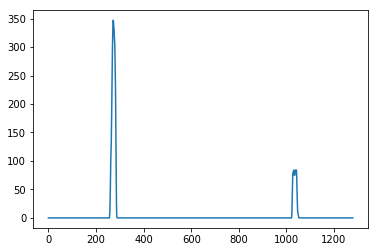

In [22]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## Sliding Window Process to Detect Hot Pixels
From that point, I can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

In [23]:
# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak's x-axis position of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left lanes)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

Visualize Sliding Window Process and Polynomial Fit

Sliding Window Process image saved in output_images directory.


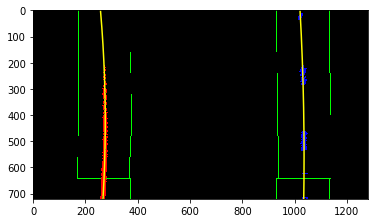

In [24]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Save Sliding Window Process image in 'output_images' folder
cv2.imwrite('output_images/straight_lines1-slidingWindow.jpg', out_img)
print('Sliding Window Process image saved in output_images directory.')

### Skip the sliding windows step once you know where the lines are
Now that I know where the lines are, in the next frame of video, I don't need to do a blind search again, but instead I can just search in a margin around the previous line position

In [25]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

Visualize Polynomial Fit when searching in a margin around the previous line position

(720, 0)

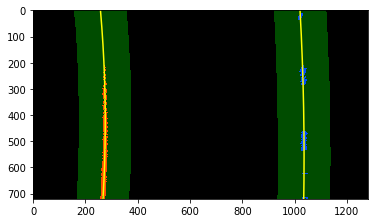

In [26]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Measuring the Curvature of the Lane Lines

In [27]:
# Define y-position where we want radius of curvature
y_eval = np.max(ploty) # corresponds to the bottom of the image

left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print('Left lane radius in pixel space:', left_curverad, '\nRight lane radius in pixel space:', right_curverad)

Left lane radius in pixel space: 5012.43638405 
Right lane radius in pixel space: 10119.7856313


Convert the calculated radius of curvature from pixel space to real world space, knowing that the lane is about 30 meters long and 3.7 meters wide

In [28]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radius of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print('Left lane radius in real-world space:', left_curverad, 'M', '\nRight lane radius in real-world space:', right_curverad, 'M')

Left lane radius in real-world space: 1638.03126392 M 
Right lane radius in real-world space: 3322.64288326 M
